In [2]:
import matplotlib.pyplot as plt
from os import listdir, system
from csv import DictReader
from statistics import mean, stdev
from numpy import arange
from random import uniform
from math import pi

In [ ]:
# --- tests for cuda and seq ---

system(f"mkdir test_out")

bins = ["dubins_cuda/bin/dubins_cuda", 
      "dubins_cuda/bin/dubins_seq",
    ]

test_folder = "dubins_cuda/test"

stat_file = open("test_out/dubins_cuda.csv", "w+")
stat_file.write("exec_name,n_points,time,unit,len,discr,ref\n")
# --- run the tests for our implementation----
for exec in bins:
    system(f"mkdir test_out/{exec.split('/')[-1]}") # it fails if the folder's already there 

    line1 = ""

    for t in listdir(test_folder):
        times = []
        
        # exmple of first line of output
        # time elapsed: 130 us Total length: 45

        out_file = f"test_out/{exec.split('/')[-1]}/out_{t}"
        for _ in range(10):
            system(f"{exec} < {test_folder}/{t} > {out_file}")
            with open(out_file, "r") as f:
                line1 = f.readline()
                time = line1.split()[2]
                times.append(float(time))
        
        avg_time = mean(times)
        exec_name = exec.split('/')[-1]
        n_points = t.split('_')[0]
        line1 = line1.split()
        unit = line1[3]
        len = line1[6]

        # format of output line
        # exec_name,n_points,time,unit,len,discr,ref

        stat_file.write(f"{exec_name},{n_points},{avg_time},{unit},{len},0,0\n")
        

stat_file.close()


In [ ]:
# --- exec tests for mpdp_saccon ---

stat_file = open("test_out/dubins_saccon.csv", "w+")
stat_file.write("exec_name,n_points,time,unit,len,discr,ref,type\n")

line1 = ""

system(f"mkdir test_out/mpdp_saccon/")
for sub in listdir("mpdp_saccon/test"):
    system(f"mkdir test_out/mpdp_saccon/{sub}")

    for t in listdir(f"mpdp_saccon/test/{sub}"):
        times = []
        out_file = f"test_out/mpdp_saccon/{sub}/out_{t}"

        for i in range(10):
            print(f"mpdp_saccon/bin/cc/main.out < mpdp_saccon/test/{sub}/{t} > {out_file}")
            system(f"mpdp_saccon/bin/cc/main.out < mpdp_saccon/test/{sub}/{t} > {out_file}")
# example of the first line of output
# TEST: 30 points with discr: 90 | refin: 8 | time: 471.539 ms | length_saccon: 59.0928 | length_nostra: 59.0928
            with open(out_file, "r") as f:
                line1 = f.readline().split('|')
                time = line1[2].split()[1]
                unit = line1[2].split()[2]
                times.append(float(time) * (1000 if unit == "ms" else 1)) # to microseconds
            
        avg_time = mean(times)
        n_points = t.split('_')[0]
        len = line1[3].split()[-1]
        discr = line1[0].split()[-1]
        ref = line1[1].split()[-1]
        
        # format of output line
        # exec_name,n_points,time,unit,len,discr,ref

        stat_file.write(f"mpdp_saccon,{n_points},{avg_time},us,{len},{discr},{ref},{sub}\n")
        

stat_file.close()
    

In [3]:
# --- exec test for dubins OMPL (dubins_seq for finding the angles + OMPL for the actual curves) ---

stat_file = open("test_out/dubins_ompl.csv", "w+")
stat_file.write("exec_name,n_points,time,unit,len,discr,ref,type\n")

exec = "dubins_ompl/build/dubins_seq_ompl"

system(f"mkdir test_out/dubins_ompl/")
for file in listdir("dubins_cuda/test"):
    times = []

    out_file = f"test_out/dubins_ompl/out_{file}"

    # 10 times per test and then we take the avg of the different exec times
    for _ in range(10):
        ret_val = -1
        while(ret_val != 0):
            print(f"{exec} < dubins_cuda/test/{file} > {out_file}")
            ret_val = system(f"{exec} < dubins_cuda/test/{file} > {out_file}")
        
        # exmple of first line of output
        # time elapsed: 130 us Total length: 45
        
        with open(out_file, "r") as f:
            line1 = f.readline().split()
            times.append(float(line1[4]))
            n_points = int(out_file.split('_')[0])
            len = line1[-1]

    stat_file.write(f"dubins_ompl,{n_points},{mean(times)},us,{len},0,0,through_q1\n")
        
stat_file.close()

dubins_ompl/build/dubins_seq_ompl < dubins_cuda/test/1000_points.txt > test_out/dubins_ompl/out_1000_points.txt


mkdir: cannot create directory ‘test_out/dubins_ompl/’: File exists


ValueError: could not convert string to float: 'Total'

In [ ]:
# --- create the CSV containing the results ---
with open("data_lengths.csv", "w") as csv:

    with open("test_out/dubins_saccon.csv", "r") as stat:
        lines = stat.readlines()
        for l in lines:
            csv.write(l)

    with open("test_out/dubins_cuda.csv", "r") as stat:
        lines = stat.readlines()[1:]
        for l in lines:
            l = l[:-1] # remove final "\n"
            csv.write(l+",through_b2\n")

    with open("test_out/dubins_ompl.csv", "r") as stat:
        lines = stat.readlines()[1:]
        for l in lines:
            csv.write(l)



In [ ]:
# --- load csv ---
outdata = []
with open(f"data_lengths.csv", "r") as f:
    csvreader = DictReader(f, delimiter=",")
    for r in csvreader:
        r["n_points"] = int(r["n_points"])
        r["time"] = float(r["time"])
        r["len"] = float(r["len"]) if r["len"] != "len" else -1
        r["discr"] = int(r["discr"])
        r["ref"] = int(r["ref"]) 
        outdata.append(r)

print([l for l in outdata if l["exec_name"] == "dubins_cuda"])

In [ ]:
# --- plot the time ---
cuda = [(l["n_points"], l["time"]) for l in outdata if l["exec_name"] == "dubins_cuda"]
cuda.sort(key = lambda x: int(x[0]))

seq = [(l["n_points"], l["time"]) for l in outdata if l["exec_name"] == "dubins_seq"] 
seq.sort(key = lambda x: int(x[0]))

saccon = [(l["n_points"], l["time"]) for l in outdata if l["exec_name"] == "mpdp_saccon" and l["type"] == "through_b2"] 
saccon.sort(key = lambda x: int(x[0]))

ompl = [(l["n_points"], l["time"]) for l in outdata if l["exec_name"] == "dubins_ompl"]
ompl.sort(key = lambda x: int(x[0]))

print(ompl)

plt.plot([str(c[0]) for c in cuda],[(float(c[1])) for c in cuda], label="cuda", marker='o')
plt.plot([str(c[0]) for c in seq],[(float(c[1])) for c in seq], label="sequential", marker='o')
plt.plot([str(c[0]) for c in saccon],[(float(c[1])) for c in saccon], label="dynamic prog", marker='o')
plt.plot([str(c[0]) for c in ompl],[(float(c[1])) for c in ompl], label="OMPL", marker='o')

plt.xlabel("N. of points")
plt.ylabel("Time [us]")

plt.legend()
plt.yscale('log')

#print(seq)

In [ ]:
# ---plot the lengths---

seq = [(l["n_points"], l["len"]) for l in outdata if l["exec_name"] == "dubins_seq"]
seq.sort(key = lambda x: int(x[0]))

saccon_b = [(l["n_points"], l["len"]) for l in outdata if l["exec_name"] == "mpdp_saccon" and l["type"] == "through_b"] 
saccon_b.sort(key = lambda x: int(x[0]))

saccon_b2 = [(l["n_points"], l["len"]) for l in outdata if l["exec_name"] == "mpdp_saccon" and l["type"] == "through_b2"] 
saccon_b2.sort(key = lambda x: int(x[0]))

ompl = [(l["n_points"], l["len"]) for l in outdata if l["exec_name"] == "dubins_ompl"]
ompl.sort(key = lambda x: int(x[0]))


arr = zip((("dubins_seq", "dyn_prog_through_b", "dyn_prog_through_b2", "dubins_ompl")), (seq, saccon_b, saccon_b2, ompl))

n_points = [str(c[0]) for c in seq]
data = {algo[0]:[float(l[1]) for l in algo[1]] for algo in arr}

for k in data.keys():
    if k != "dubins_seq":
        for i in range(len(data[k])):
            data[k][i] = data[k][i] / data["dubins_seq"][i]

data["dubins_seq"] = [1 for _ in range(len(seq))]

x = arange(len(n_points))
width = 0.1  # the width of the bars1
multiplier = 0

fig, ax = plt.subplots(figsize=(18, 6))

for n, l in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, l, width, label=n)
    ax.bar_label(rects, padding=3, fmt="%.3f")
    multiplier += 1.5

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("n. of points")
ax.set_ylabel('Length w.r.t length found with sequential algo (%)')
ax.set_title('Length of paths given by different algorithms')
ax.set_xticks(x + width, n_points)
ax.legend(ncol=2)
ax.set_ylim(.90, 1.20)


plt.show()


# dubins_OMPL vs dubins_RP


In [2]:
# --- utility functions to read the map ---

def collide(x, y, object):
    # object: (bottom-left, top-right)
    return object[0][0] <= x <= object[1][0] and object[0][1] <= y <= object[1][1]

def points_ok(sx, sy, gx, gy, map_obs):
    for obj in map_obs:
        if collide(sx, sy, obj) or collide(gx, gy, obj):
            return False
    return True

map = "dubins_ompl/img/warehouse2.svg"
map_top_left = (5, -5)
map_bot_right = (120, -76)

# (bottom left, top right)
map_obs = [((11.5201, -20.0169),(49.1801, -9.86222)),
((53.9015, -69.9063),(58.4651, -65.4007)),
((55.8886, -66.622),(60.4522, -62.1164)),
((60.4028, -69.1561),(64.9944, -64.6074)),
((58.2029, -72.8409),(62.7584, -68.3474)),
((11.5201, -36.4401),(49.1801, -26.2855)),
((11.7452, -53.4855),(49.4053, -43.3308)),
((11.4582, -69.6553),(49.1183, -59.5006)),
((60.7308, -59.3659),(65.1676, -55.0232)),
((59.28, -55.812),(63.7168, -51.4693)),
((65.6451, -57.6818),(70.1005, -53.3168)),
((63.9391, -53.7599),(68.3945, -49.3948)),
((56.4534, -39.2001),(60.9738, -34.7542)),
((58.2051, -35.7845),(62.7254, -31.3386)),
((60.9535, -41.8232),(65.4604, -37.3948)),
((62.4279, -37.8832),(66.9348, -33.4547)),
((60.2327, -24.5716),(64.6402, -20.2636)),
((58.4251, -20.3871),(62.9837, -15.8888)),
((64.8183, -22.3156),(69.2462, -17.9835)),
((63.2073, -18.3537),(67.6352, -14.0215)),
((0.05376, -40.2254),(4.10892, -0.14494)),
((0.03316, -81.2676),(4.08832, -41.1871)),
((97.2841, -20.5199),(101.063, -16.9131)),
((101.39, -20.5199),(105.168, -16.9131)),
((105.593, -20.5199),(109.371, -16.9131)),
((109.699, -20.6158),(113.477, -17.0091)),
((88.1345, -36.556),(91.913, -32.9493)),
((92.2404, -36.556),(96.0188, -32.9493)),
((96.4434, -36.556),(100.222, -32.9493)),
((100.742, -36.6039),(104.52, -32.9972)),
((105.162, -36.556),(108.94, -32.9493)),
((109.364, -36.556),(113.143, -32.9493)),
((88.0535, -53.2604),(91.832, -49.6537)),
((92.3277, -53.3563),(96.1062, -49.7497)),
((96.7112, -53.4547),(100.49, -49.8481)),
((100.817, -53.5507),(104.595, -49.944)),
((88.4651, -20.5199),(92.2436, -16.9131)),
((92.6681, -20.5199),(96.4466, -16.9131)),
((97.2841, -15.7581),(101.063, -12.1514)),
((101.39, -15.7581),(105.168, -12.1514)),
((105.593, -15.7581),(109.371, -12.1514)),
((109.699, -15.854),(113.477, -12.2474)),
((88.1345, -31.7942),(91.913, -28.1876)),
((92.2404, -31.7942),(96.0188, -28.1876)),
((96.4434, -31.7942),(100.222, -28.1876)),
((100.742, -31.8421),(104.52, -28.2354)),
((105.162, -31.7942),(108.94, -28.1876)),
((109.364, -31.7942),(113.143, -28.1876)),
((88.0535, -48.4986),(91.832, -44.8919)),
((92.3277, -48.5945),(96.1062, -44.9879)),
((96.7112, -48.693),(100.49, -45.0863)),
((100.817, -48.7888),(104.595, -45.1822)),
((88.4651, -15.7581),(92.2436, -12.1514)),
((92.6681, -15.7581),(96.4466, -12.1514)),
((77.0048, -34.4294),(81.0648, -0.26395)),
((76.9856, -81.1167),(81.0426, -43.3463)),
((105.166, -53.4547),(108.944, -49.8481)),
((109.272, -53.5507),(113.05, -49.944)),
((105.166, -48.693),(108.944, -45.0863)),
((109.272, -48.7888),(113.05, -45.1822)),
((4.49985, -4.08999),(40.0289, -0.03123)),
((40.5771, -4.21816),(76.4828, -0.15972)),
((4.83402, -80.8605),(40.3512, -76.8017)),
((40.8989, -80.9888),(76.4162, -76.9301)),
((81.8754, -4.49009),(119.646, -0.43311)),
((120.392, -40.6027),(124.447, -0.44879)),
((120.371, -80.7697),(124.427, -41.2832)),
((87.5942, -69.4373),(91.3727, -65.8306)),
((91.8684, -69.5332),(95.6469, -65.9266)),
((96.2519, -69.6316),(100.03, -66.025)),
((100.358, -69.7276),(104.136, -66.1209)),
((87.5942, -64.6755),(91.3727, -61.0688)),
((91.8684, -64.7715),(95.6469, -61.1648)),
((96.2519, -64.8699),(100.03, -61.2632)),
((100.358, -64.9657),(104.136, -61.3591)),
((104.707, -69.6316),(108.485, -66.025)),
((108.812, -69.7276),(112.591, -66.1209)),
((104.707, -64.8699),(108.485, -61.2632)),
((108.812, -64.9657),(112.591, -61.3591)),
((81.8754, -80.7902),(119.646, -76.7332)),]



In [ ]:
# --- test fixed timeout ---

max_time = 3
n_points = 100
n_rep = 5

csv = open(f"test_out/ompl_survival_3_seconds_fixed.csv", "w+")
csv.write("test;exec;success_rate;avg_len\n")

for _ in range(n_points):

    while True:
        start_x = uniform(map_top_left[0], map_bot_right[0])
        start_y = uniform(map_top_left[1], map_bot_right[1])

        goal_x = uniform(map_top_left[0], map_bot_right[0])
        goal_y = uniform(map_top_left[1], map_bot_right[1])

        if points_ok(start_x, start_y, goal_x, goal_y, map_obs):
            break

    #print(f"\nStart: ({start_x}, {start_y}), Goal: ({goal_x}, {goal_y})")


    lengths_rrt = []
    lengths_rrt_dubins = []
    for _ in range(n_rep):
        
        th0 = pi / 2
        thf = th0

        #print(f"\t{exec}: ", end='')

        rv = system(f"dubins_ompl/build/rrt {start_x} {start_y} {goal_x} {goal_y} {map} {max_time} > temp.out 2> /dev/null")
        if rv == 0:
            # example line:
            # time: 21700062.415000 us | len: 154.422243 | th0: 0 | thf: 3.14
            with open("temp.out", "r") as f:
                last_line = f.readlines()[-1]
                th0 = float(last_line.split()[-4])
                thf = float(last_line.split()[-1])
                l = float(last_line.split()[5])
                lengths_rrt.append(l)
                

        rv = system(f"dubins_ompl/build/rrt_dubins {start_x} {start_y} {th0} {goal_x} {goal_y} {thf} {map} {max_time} > temp.out 2> /dev/null")
        if rv == 0:
            # example line:
            # time: 21700062.415000 us | len: 154.422243
            with open("temp.out", "r") as f:
                l = float(f.readlines()[-1].split()[-1])
                lengths_rrt_dubins.append(l)

    print("rrt: ", lengths_rrt)
    print("dubins: ", lengths_rrt_dubins)
    csv.write(f"({start_x},{start_y})->({goal_x},{goal_y});rrt;{len(lengths_rrt) / n_rep};{mean(lengths_rrt) if len(lengths_rrt) != 0 else 0}\n")
    csv.write(f"({start_x},{start_y})->({goal_x},{goal_y});rrt_dubins;{len(lengths_rrt_dubins) / n_rep};{mean(lengths_rrt_dubins) if len(lengths_rrt_dubins) != 0 else 0}\n")

csv.close()


In [ ]:
# --- load fixed timeout survival csv ---
outdata = []
with open(f"test_out/ompl_survival_3_seconds_fixed.csv", "r") as f:
    csvreader = DictReader(f, delimiter=";")
    for r in csvreader:
        r["success_rate"] = float(r["success_rate"])
        r["avg_len"] = float(r["avg_len"])
        if(r["avg_len"] > 0):
            outdata.append(r)

print(outdata)

In [ ]:
# --- plot survial plot fixed timeout ---

outdata.sort(key=lambda e:e["avg_len"])

rrt = [e["avg_len"] for e in outdata if e["exec"] == "rrt"]
rrt_dubins = [e["avg_len"] for e in outdata if e["exec"] == "rrt_dubins"]

print(rrt)
print(rrt_dubins)

rrt.sort()
rrt_dubins.sort()

rrt_y = [rrt[0]]
for i in rrt[1:]:
    rrt_y.append(rrt_y[-1] + i)

rrt_dub_y = [rrt_dubins[0]]
for i in rrt_dubins[1:]:
    rrt_dub_y.append(rrt_dub_y[-1] + i)

plt.plot(arange(1, len(rrt) +1), rrt_y, label="rrt")
plt.plot(arange(1, len(rrt_dubins) + 1), rrt_dub_y, label="rrt_dubins")

plt.xlabel("N. of successful test")
plt.ylabel("Sum of lenghts")

plt.legend()

In [3]:
# --- survival plot multi timeout parameters ---

max_time = [.05, .1, .2 , .5, 1, 2]
n_points = 100
n_rep = 5

In [4]:
# --- test multi timeout ---

csv = open(f"test_out/ompl_survival_multi_timeout.csv", "w+")
csv.write("test;exec;timeout;time;len\n")

for t in max_time:

    for _ in range(n_points):

        while True:
            start_x = uniform(map_top_left[0], map_bot_right[0])
            start_y = uniform(map_top_left[1], map_bot_right[1])

            goal_x = uniform(map_top_left[0], map_bot_right[0])
            goal_y = uniform(map_top_left[1], map_bot_right[1])

            if points_ok(start_x, start_y, goal_x, goal_y, map_obs):
                break

        #print(f"\nStart: ({start_x}, {start_y}), Goal: ({goal_x}, {goal_y})")


        for _ in range(n_rep):
            th0 = pi / 2
            thf = th0
            length = -1
            time = -1

            rv = system(f"dubins_ompl/build/rrt {start_x} {start_y} {goal_x} {goal_y} {map} {t} > temp.out 2>> rrt_stderr_out")
            if rv == 0:
                # example line:
                # time: 21700062.415000 us | len: 154.422243 | th: 0 | thf: 1
                with open("temp.out", "r") as f:
                    last_line = f.readlines()[-1]
                    th0 = float(last_line.split()[-4])
                    thf = float(last_line.split()[-1])
                    time = float(last_line.split()[1])
                    length = float(last_line.split()[5])
            csv.write(f"({start_x},{start_y})->({goal_x},{goal_y});rrt;{t};{time};{length}\n")

            length = -1
            time = -1
            rv = system(f"dubins_ompl/build/rrt_dubins {start_x} {start_y} {th0} {goal_x} {goal_y} {thf} {map} {t} > temp.out 2> /dev/null")
            if rv == 0:
                # example line:
                # time: 21700062.415000 us | len: 154.422243
                with open("temp.out", "r") as f:
                    last_line = f.readlines()[-1]
                    time = float(last_line.split()[1])
                    length = float(last_line.split()[-1])
            csv.write(f"({start_x},{start_y})->({goal_x},{goal_y});rrt_dubins;{t};{time};{length}\n")
    
csv.close()


In [5]:
# --- load ompl_survival_multi_timeout csv ---
outdata = []
with open("test_out/ompl_survival_multi_timeout.csv", "r") as f:
    csvreader = DictReader(f, delimiter=";")
    for r in csvreader:
        r["timeout"] = float(r["timeout"])
        r["time"] = float(r["time"])
        r["len"] = float(r["len"])
        outdata.append(r)
  
print(outdata)

[{'test': '(96.14690398536585,-31.495748112688304)->(18.272962677768597,-71.31956557914047)', 'exec': 'rrt', 'timeout': 0.05, 'time': -1.0, 'len': -1.0}, {'test': '(96.14690398536585,-31.495748112688304)->(18.272962677768597,-71.31956557914047)', 'exec': 'rrt_dubins', 'timeout': 0.05, 'time': -1.0, 'len': -1.0}, {'test': '(96.14690398536585,-31.495748112688304)->(18.272962677768597,-71.31956557914047)', 'exec': 'rrt', 'timeout': 0.05, 'time': 60517.412, 'len': 103.151232}, {'test': '(96.14690398536585,-31.495748112688304)->(18.272962677768597,-71.31956557914047)', 'exec': 'rrt_dubins', 'timeout': 0.05, 'time': -1.0, 'len': -1.0}, {'test': '(96.14690398536585,-31.495748112688304)->(18.272962677768597,-71.31956557914047)', 'exec': 'rrt', 'timeout': 0.05, 'time': -1.0, 'len': -1.0}, {'test': '(96.14690398536585,-31.495748112688304)->(18.272962677768597,-71.31956557914047)', 'exec': 'rrt_dubins', 'timeout': 0.05, 'time': -1.0, 'len': -1.0}, {'test': '(96.14690398536585,-31.495748112688304)

{0.05: 367, 0.1: 411, 0.2: 475, 0.5: 485, 1: 493, 2: 496}


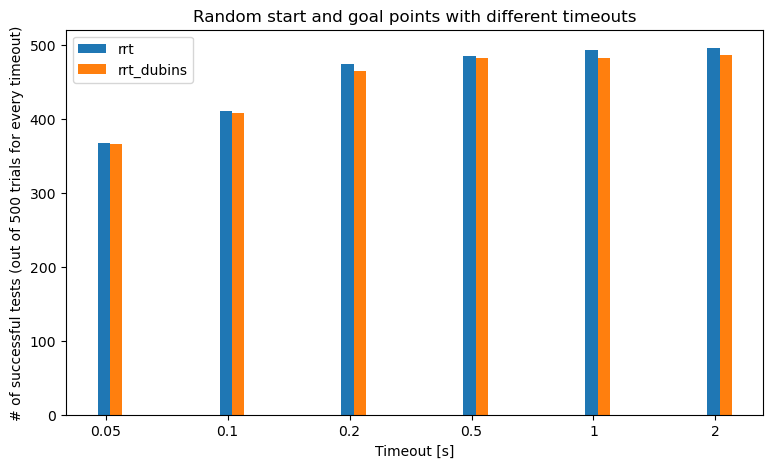

In [6]:
# --- plot histogram ---

histogram_rrt = {t:0 for t in max_time}
for e in outdata:
    histogram_rrt[e["timeout"]] += (e["exec"] == "rrt") and e["time"] > 0

histogram_rrt_dub = {t:0 for t in max_time}
for e in outdata:
    histogram_rrt_dub[e["timeout"]] += (e["exec"] == "rrt_dubins") and e["time"] > 0

print(histogram_rrt)

x = arange(len(histogram_rrt.values()))

width = 0.1  # the width of the bars1
multiplier = 0

fig, ax = plt.subplots(figsize=(9, 5))

rects = plt.bar(x, list(histogram_rrt.values()), width, label="rrt")
#ax.bar_label(rects, fmt="%.3f")

rects = plt.bar(x + width, list(histogram_rrt_dub.values()), width, label="rrt_dubins")
#ax.bar_label(rects)


# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel("Timeout [s]")
plt.ylabel(f'# of successful tests (out of {n_points * n_rep} trials for every timeout)')
plt.title(f'Random start and goal points with different timeouts')
plt.xticks(x + width / len(max_time), [str(t) for t in max_time])
plt.legend()


In [7]:
# --- multi-timeout table for mean and std_dev of lenghts ---
t = {(e["test"], e["timeout"]):{"rrt":[], "rrt_dubins":[]} for e in outdata}

for e in outdata:
    if e["len"] > 0:
        t[(e["test"], e["timeout"])][e["exec"]].append(e["len"])

i = 1
for k, v in t.items():
    v["rrt"] = [mean(v["rrt"]), stdev(v["rrt"])] if len(v["rrt"]) > 2 else [-1, -1]
    v["rrt_dubins"] = [mean(v["rrt_dubins"]), stdev(v["rrt_dubins"])] if len(v["rrt_dubins"]) > 2 else [-1, -1]

    print(f'test {i} with timeout {k[1]}:\n\trrt: mean={v["rrt"][0]} stdev={v["rrt"][1]}\n\trrt_dubins: mean={v["rrt_dubins"][0]} stdev={v["rrt_dubins"][1]}')
    i += 1

test 1 with timeout 0.05:
	rrt: mean=-1 stdev=-1
	rrt_dubins: mean=-1 stdev=-1
test 2 with timeout 0.05:
	rrt: mean=-1 stdev=-1
	rrt_dubins: mean=-1 stdev=-1
test 3 with timeout 0.05:
	rrt: mean=83.29508475 stdev=1.0709639241341944
	rrt_dubins: mean=-1 stdev=-1
test 4 with timeout 0.05:
	rrt: mean=38.9908802 stdev=1.2199889377097632
	rrt_dubins: mean=46.3938644 stdev=3.120760318150501
test 5 with timeout 0.05:
	rrt: mean=72.6889396 stdev=1.5808327304379155
	rrt_dubins: mean=77.6337768 stdev=1.5696271040176097
test 6 with timeout 0.05:
	rrt: mean=17.597301 stdev=0.0
	rrt_dubins: mean=19.196518 stdev=0.0
test 7 with timeout 0.05:
	rrt: mean=49.6369975 stdev=0.11983011442454711
	rrt_dubins: mean=68.90208825 stdev=29.24042841241272
test 8 with timeout 0.05:
	rrt: mean=70.4771568 stdev=3.816784988369363
	rrt_dubins: mean=70.4722692 stdev=5.269460178390541
test 9 with timeout 0.05:
	rrt: mean=39.5267884 stdev=0.7179034405536711
	rrt_dubins: mean=41.406429 stdev=0.4292274524264488
test 10 wit

{0.05: [83.29508475, 38.9908802, 72.6889396, 17.597301, 49.6369975, 70.4771568, 39.5267884, 33.839897666666666, 54.3846225, 79.10643866666666, 49.6122068, 15.868231, 53.762099, 64.1754476, 33.78104733333333, 32.3550456, 25.957157, 50.381812333333336, 35.0133402, 85.10329, 66.65773250000001, 13.941867, 21.8360534, 97.95001366666666, 12.458484, 24.5307008, 107.483468, 74.9980505, 51.005708399999996, 83.642554, 81.25484900000001, 53.939868, 70.55908666666667, 103.03401433333333, 63.5491866, 29.9068538, 55.529260199999996, 52.215517500000004, 52.3953485, 3.504587, 90.7388934, 58.1639264, 4.079169, 86.854859, 8.540239, 35.185587399999996, 88.69146549999999, 44.199152500000004, 124.61744999999999, 90.51047333333334, 25.853993, 34.685497, 85.759171, 33.733379666666664, 19.830555, 8.497612, 74.1344778, 133.60300466666666, 74.36319166666667, 40.4739352, 7.63155, 22.0924192, 58.32161266666667, 25.450648, 6.371424, 62.756008, 54.4880142, 38.92867925, 15.5592392, 59.90887725, 57.351171, 50.960611,

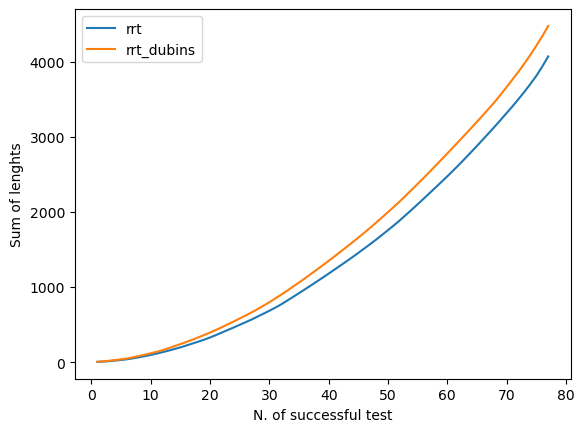

In [8]:
# --- plot survial plot multi timeout ---

rrt = {k[1]:[v2["rrt"][0] for k2, v2 in t.items() if k2[1] == k[1] and v2["rrt"][0] > 0] for k in t.keys()}
rrt_dubins = {k[1]:[v2["rrt_dubins"][0] for k2, v2 in t.items() if k2[1] == k[1] and v2["rrt_dubins"][0] > 0] for k in t.keys()}

print(rrt)
print(rrt_dubins)

for v in rrt.values():
    v.sort()
for v in rrt_dubins.values():
    v.sort()

rrt_y = {}
for k, v in rrt.items():
    if len(v) > 0:
        rrt_y[k] = [v[0]]
    else:
        rrt_y[k] = [-1]

for k, v in rrt.items():
    for i in v[1:]:
        rrt_y[k].append(rrt_y[k][-1] + i)

        

rrt_dub_y = {}
for k, v in rrt_dubins.items():
    if len(v) > 0:
        rrt_dub_y[k] = [v[0]]
    else:
        rrt_dub_y[k] = [-1]

for k, v in rrt_dubins.items():
    for i in v[1:]:
        rrt_dub_y[k].append(rrt_dub_y[k][-1] + i)

key = .05

print(rrt_y[key])
print(rrt_dub_y[key])

plt.plot(arange(1, len(rrt_y[key]) + 1), rrt_y[key], label="rrt")
plt.plot(arange(1, len(rrt_dub_y[key]) + 1), rrt_dub_y[key], label="rrt_dubins")


plt.xlabel("N. of successful test")
plt.ylabel("Sum of lenghts")

plt.legend()